# UN voting PCA and clustering 

In [1]:
import pandas as pd

un_data = pd.read_csv('~/Library/CloudStorage/Dropbox/5. LSE MPA DSPP/Cursos/Capstone PP4B5/fcdo_dspp_capstone/un_data/2024_09_12_ga_resolutions_voting.csv')

#online location 
#un_data = pd.read_csv('https://digitallibrary.un.org/record/4060887/files/2024_09_12_ga_resolutions_voting.csv?')

# cleaning country names to have a 1:1 match to country code

df_names = un_data.drop_duplicates(subset=['ms_code'], keep='first')
df_names = df_names[['ms_code', 'ms_name']]

un_data = un_data.drop(columns='ms_name')  # Drop the original ms_name column to avoid conflicts
un_data = pd.merge(un_data, df_names, on='ms_code', how='left')  # Perform the merge

/var/folders/7b/vjmsjgqx12j148x13wgz79cr0000gn/T/ipykernel_11201/828393314.py:3: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  un_data = pd.read_csv('~/Library/CloudStorage/Dropbox/5. LSE MPA DSPP/Cursos/Capstone PP4B5/fcdo_dspp_capstone/un_data/2024_09_12_ga_resolutions_voting.csv')


## 1. PCA of UN voting data, 1946 to present 
We make one PCA shot for each year in the data, using the votes of five years  

next steps:  

1. Force more stable data orientation, in some shots it clearly maintains the structure but the data is rotated.  
        Gonzalos sugestion: "For all  t , apply a general PCA (excluding  t  itself). Then, using the weights of that general PCA, apply the linear transformation to each  t ."  
        
2. Rescale and recenter PCA results to have a -1 to 1 range in all PCA runs and also compress outlier, not just the arithmetic lineal uniform compression 
        
3. Explore ranking of the most relevant votations in separating the data, need to check how large are the numbers, probably is not useful really  
  
4. Append other data like country population, coutry GDP and country GDP PPP, to make graphs with it. Also maybe append trade data and stuff, specillly for cluster prediction  

5. USe NLP to classify votes ideally by tech topic, but at least as tech-non tech 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import plotly.express as px

# selecting vars 
un_votes = un_data[['undl_id', 'ms_code', 'ms_name', 'ms_vote', 'date']]

# Recode votes
recode_map = {'A': 0, 'Y': 1, 'N': -1}
un_votes['ms_vote'] = un_votes['ms_vote'].map(recode_map)
un_votes['year'] = pd.to_datetime(un_votes['date']).dt.year  # Extract year
un_votes['undl_id'] = un_votes['undl_id'].astype(str)

# Sort data by year
un_votes = un_votes.sort_values('year')

# Initialize an empty DataFrame to store PCA and cluster results
results = pd.DataFrame(columns=['ms_code', 'ms_name', 'PCA1', 'PCA2', 'year'])

# Rolling PCA and clustering process
years = sorted(un_votes['year'].unique())
window_size = 5

for idx, current_year in enumerate(years):
    # Determine the range of years to include in the rolling window
    start_idx = max(0, idx - window_size + 1)
    years_window = years[start_idx:idx + 1]
    
    # Filter data for the rolling window
    window_data = un_votes[un_votes['year'].isin(years_window)]
    
    # Pivot data to wide format
    pivot_window = window_data.pivot(
        index=['ms_code', 'ms_name'], 
        columns='undl_id', 
        values='ms_vote'
    ).fillna(0).reset_index()

    # Extract numerical data and preserve column names
    numerical_data = pivot_window.loc[:, pivot_window.columns.difference(['ms_code', 'ms_name'])]
    
    # One-Hot Encode Numerical Columns
    one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    one_hot_encoded = one_hot_encoder.fit_transform(numerical_data)

    # Combine one-hot encoded data with the rest of the DataFrame
    # Use the original column names to generate feature names
    names = one_hot_encoder.get_feature_names_out()
    one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=names)

# Concatenate with the rest of the DataFrame
    processed_data = pd.concat(
    [pivot_window.drop(columns=numerical_data).reset_index(drop=True), 
    one_hot_encoded_df],
    axis=1
    )
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(processed_data.select_dtypes(include=[np.number]))
    
    
    # Perform PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_data)

    clustering = AgglomerativeClustering(n_clusters=4, linkage='ward')
    labels = clustering.fit_predict(pca_result)
    labels = labels.astype(str)


    # Combine PCA results and clustering labels with metadata
    window_results = pd.DataFrame({
        'ms_code': pivot_window['ms_code'],
        'ms_name': pivot_window['ms_name'],
        'PCA1': pca_result[:, 0],
        'PCA2': pca_result[:, 1],
        'year': current_year,
        'cluster': labels
    })

     
    
    # Append to the results DataFrame
    results = pd.concat([results, window_results], ignore_index=True)




/var/folders/7b/vjmsjgqx12j148x13wgz79cr0000gn/T/ipykernel_11201/4103495984.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7b/vjmsjgqx12j148x13wgz79cr0000gn/T/ipykernel_11201/4103495984.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7b/vjmsjgqx12j148x13wgz79cr0000gn/T/ipykernel_11201/4103495984.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [99]:
results['cluster'] = results['cluster'].astype('int').astype('category')


In [101]:

# Create an interactive scatter plot with a slider
fig = px.scatter(
    results,
    x='PCA1',
    y='PCA2',
    color='cluster',
    animation_frame='year',
    hover_data={'ms_name': True, 'PCA1': False, 'PCA2': False},
    title='PCA on five year rolling window',
    labels={'PCA1': 'Principal component 1', 'PCA2': 'Principal component 2'},
    template='plotly_white'
)

fig.update_layout(
    font=dict(
        family='Helvetica', 
        size=14,         # Font size
        color='black'     # Font color
    ),
    title_x=0.5  # Center the title
)

# Show the plot
fig.show()

fig.write_html("outputs/interactive_pca_plot with windows.html")




If you don't see all the points (always +150), yoo need to zoom out. 

Each year is a PCA runned over 5 years (the corresponding year and the 5 previous years)

## 2. experimental. testing for static window of year, clustering and a test for plotting limits between clusters

In [56]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


un_votes = un_data[['undl_id', 'ms_code', 'ms_name',
                    'ms_vote', 'date']]


un_votes = un_votes[(un_votes['ms_vote'] != 'NV')  & (un_votes['date'] > "2023-01-01")]

recode_map = {'A': 0, 'Y': 1, 'N': -1}
un_votes['ms_vote'] = un_votes['ms_vote'].map(recode_map)



pivot_un = un_votes.pivot(index=['ms_code'], columns='undl_id', values='ms_vote')

# Resetting the index if needed
pivot_un = pivot_un.reset_index().fillna(0)



numerical_data = pivot_un.select_dtypes(exclude=['object'])

# Step 2: Standardize the data (important for PCA)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_data)

# Step 3: Apply PCA
pca = PCA(n_components=2)  # We use 2 components for visualization
pca_result = pca.fit_transform(scaled_data)

# Add PCA components back to the dataframe (optional)
df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

# Step 4: Add commission and numerical ID to the PCA dataframe
df_pca['ms_code'] = pivot_un['ms_code']




### Clustering and dendogram 

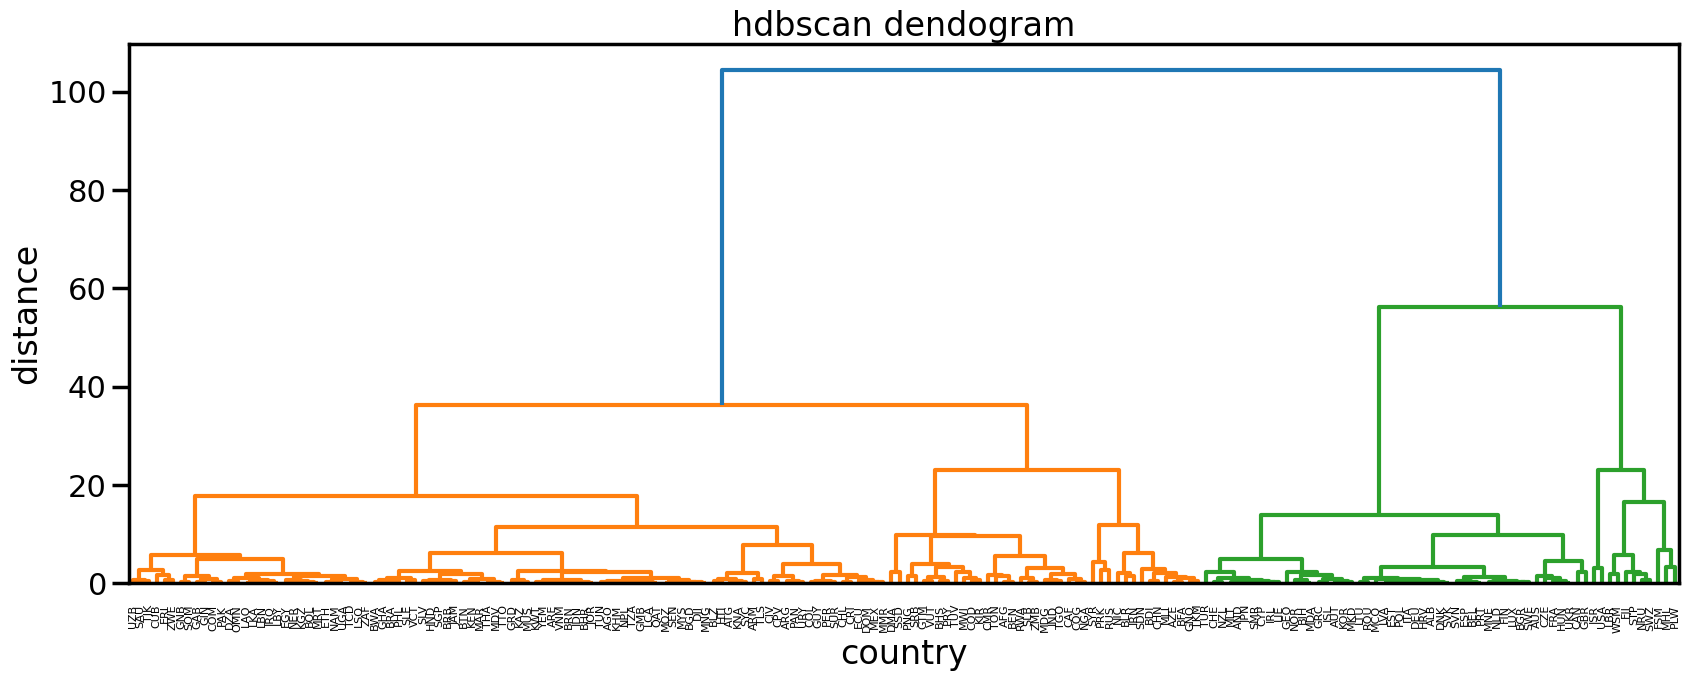

<Figure size 1200x800 with 0 Axes>

In [64]:
# Step 5: Perform hierarchical clustering (for dendrogram)
# Use the distance matrix for clustering. We use the 
# PCA results to make the clustering 
import scipy.cluster.hierarchy as sch
distance_matrix = sch.distance.pdist(pca_result, metric='euclidean')
linkage_matrix = sch.linkage(distance_matrix, method='ward')

# Step 6: Plot the dendrogram with numerical IDs
plt.figure(figsize=(20, 7))
sch.dendrogram(linkage_matrix, labels=df_pca['ms_code'].values.astype(str), leaf_rotation=90, leaf_font_size=8)
plt.title('hdbscan dendogram')
plt.xlabel('country')
plt.ylabel('distance')
plt.show()

# Step 7: Plot the PCA results (Principal Components 1 and 2) with color-coded work groups
plt.figure(figsize=(12, 8))

### elbow test to decide number of clusters 

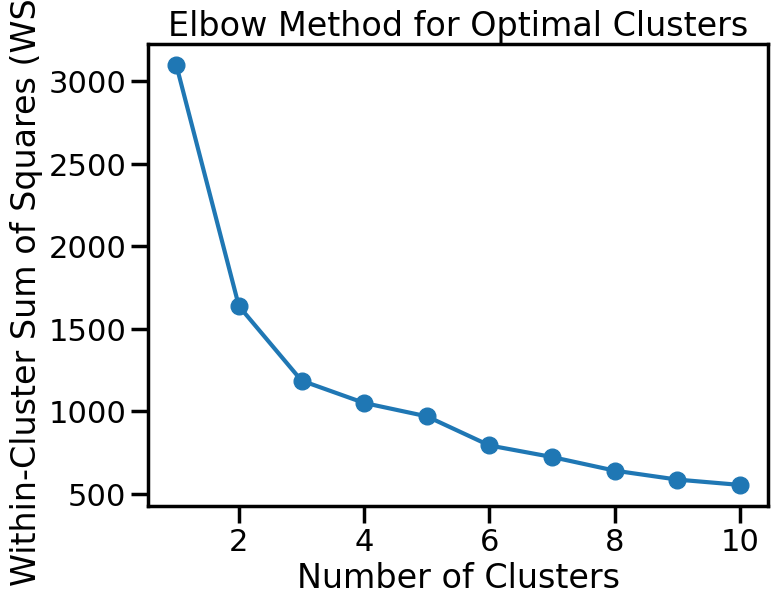

ValueError: Length of values (193) does not match length of index (192)

In [80]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import numpy as np


# Step 2: Elbow method to determine the optimal number of clusters
wss = []
max_clusters = 10  # Test up to 10 clusters
for k in range(1, max_clusters + 1):
    clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = clustering.fit_predict(pca_result)
    centroids = [pca_result[labels == c].mean(axis=0) for c in np.unique(labels)]
    wss.append(sum(np.linalg.norm(pca_result[labels == c] - centroids[i], axis=1).sum() for i, c in enumerate(np.unique(labels))))

# Plot the elbow curve. Change optimal custer if you want. I left 4 as default 
plt.figure(figsize=(8, 6))
plt.plot(range(1, max_clusters + 1), wss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WSS)')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

# Step 3: Choose the optimal number of clusters and label the data
optimal_clusters = 4
clustering = AgglomerativeClustering(n_clusters=optimal_clusters, linkage='ward')
labels = clustering.fit_predict(pca_result)

# Step 4: Add cluster labels to the data
# Assuming 'countries' is a list of country names corresponding to rows in pca_results
clustered_data = df_pca.copy()
clustered_data['cluster'] = labels

# Display results
print(clustered_data[['cluster']])

### static plotting with clusters

In [81]:
import plotly.express as px

clustered_data = pd.merge(clustered_data, df_names[['ms_code', 'ms_name']], on='ms_code', how='left')

clustered_data['cluster'] = clustered_data['cluster'].astype('category')

# Create the plot
fig = px.scatter(
    clustered_data,
    x='PC1',
    y='PC2',
    color='cluster',

    hover_data={
    'ms_name': True,          # Include TagName
    'PC1': False,             # Exclude PC1 (can still be used as x-axis)
    'PC2': False,             # Exclude PC2
    },
    title='Clustered PCA Plot of UN votes, 2021-2024'
)

# Update font for all text
fig.update_layout(
    font=dict(
        family='Times New Roman',  # Font family (e.g., 'Arial', 'Courier New', etc.)
        size=14,         # Font size
        color='black'     # Font color
    ),
    title_x=0.5  # Center the title
)

# Show the plot
fig.show()



KeyError: 'cluster'

### static plotting with clusters and Voronoi boundaries between  clusters

/var/folders/7b/vjmsjgqx12j148x13wgz79cr0000gn/T/ipykernel_11201/3108014151.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



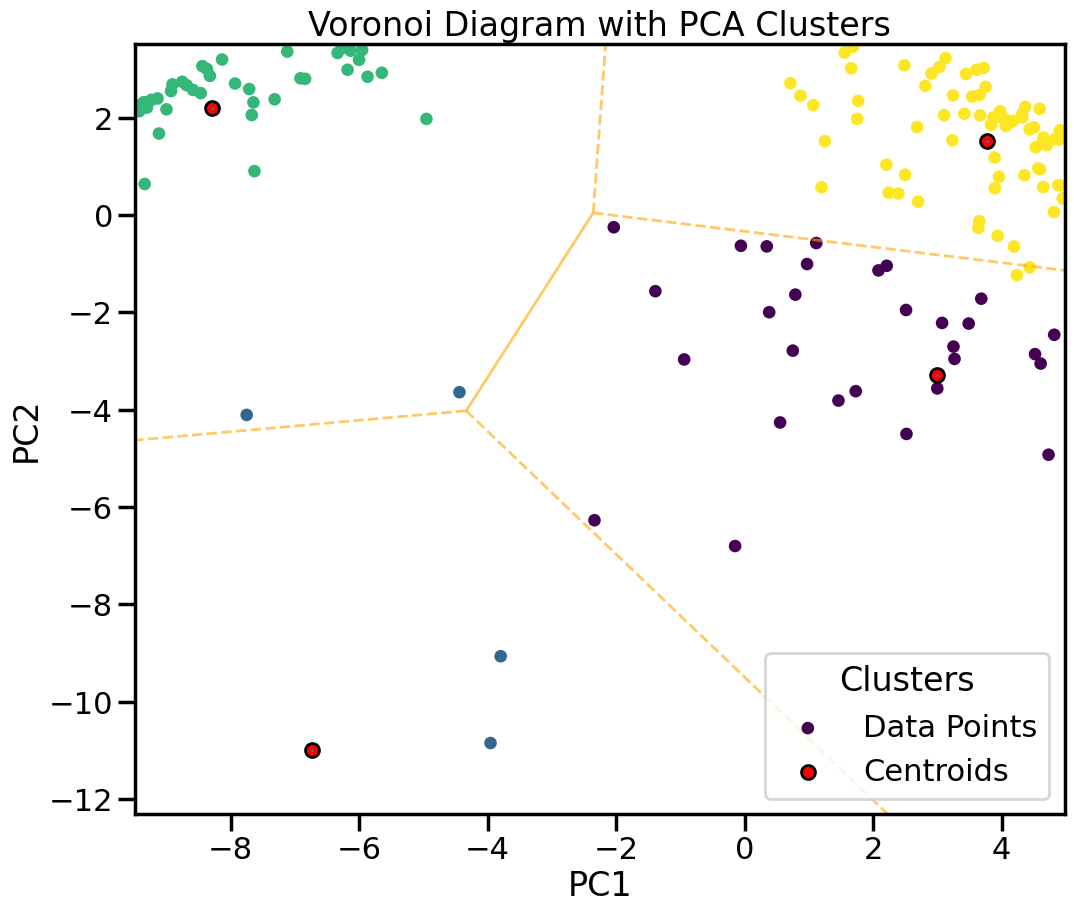

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import pandas as pd

# Assuming clustered_data contains your PCA data
# clustered_data should have the columns: 'PC1', 'PC2', 'cluster'

# Calculate cluster centroids
centroids = clustered_data.groupby('cluster')[['PC1', 'PC2']].mean().reset_index()
points = centroids[['PC1', 'PC2']].values  # Use centroids for Voronoi

# Generate the Voronoi diagram
vor = Voronoi(points)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot PCA data points colored by cluster
scatter = ax.scatter(
    clustered_data['PC1'], clustered_data['PC2'],
    c=clustered_data['cluster'].astype('category').cat.codes,  # Ensure colors match cluster categories
    cmap='viridis', s=50, label='Data Points'
)

# Overlay Voronoi diagram
voronoi_plot_2d(vor, ax=ax, show_vertices=False, 
                line_colors='orange', line_width=2, 
                line_alpha=0.6, point_size=2)

# Plot centroids
ax.scatter(
    centroids['PC1'], centroids['PC2'],
    color='red', label='Centroids', s=100, edgecolor='black'
)

# Add legend
ax.legend(title='Clusters')

# Add labels and title
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Voronoi Diagram with PCA Clusters')

plt.show()